#Prediciendo con Arima

ARIMA responde a las siglas de Media móvil integrada autorregresiva, esta clase de modelos basan su funcionamiento en el auto-ajuste de los datos presentes en la serie temporal a estudiar. Se dice que es autoregresiva pues utiliza valores pasados, por ejemplo, esta clase de modelos se puede usar para a partir de valores de ventas pasadas predecir las futuras o nuestro ejemplo a partir de valores pasados de intensidad predecir valores futuros de la misma. ARIMA utiliza medias móviles retardadas para suavizar los datos de las series temporales. Un punto a considerar es que ARIMA hará buenas predicciones para aquellas series cuyos valores futuros se parezcan a sus valores futuros.
Para poder disponer de una línea base vamos a uilizar el modelo Arima para predecir, y en base a lo conseguido podemos dictaminar que es lo mínimo que podemos conseguir.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.8 MB/s eta 0:00:00


In [ ]:
import pickle
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import os




In [ ]:



with open('/content/gdrive/MyDrive/PatronesComportamiento/trainingX.pkl', 'rb') as file:
        X_train=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/trainingy.pkl', 'rb') as file:
        y_train=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/testX.pkl', 'rb') as file:
        X_test=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/testy.pkl', 'rb') as file:
        y_test=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/validateX.pkl', 'rb') as file:
        X_val=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/validatey.pkl', 'rb') as file:
        y_val=pickle.load(file)


with open('/content/gdrive/MyDrive/PatronesComportamiento/mySeriesInten.pkl', 'rb') as file:
        mySeries=pickle.load(file)


Primero vamos a hacer una simple predicción de una solo serie temporal, tan solo queremos predecir la última parte de la misma y representaremos para ver gráficamente el resultado obtenido.

28
----                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  287
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -317.115
Date:                Mon, 08 May 2023   AIC                            642.231
Time:                        07:54:18   BIC                            656.855
Sample:                             0   HQIC                           648.093
                                - 287                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9370      0.040     23.317      0.000       0.858       1.016
ma.L1         -0.9614      0.067    -14.408      0.000      -1.092      -0.831
ma.L2          0.1315      0.057      2.310 

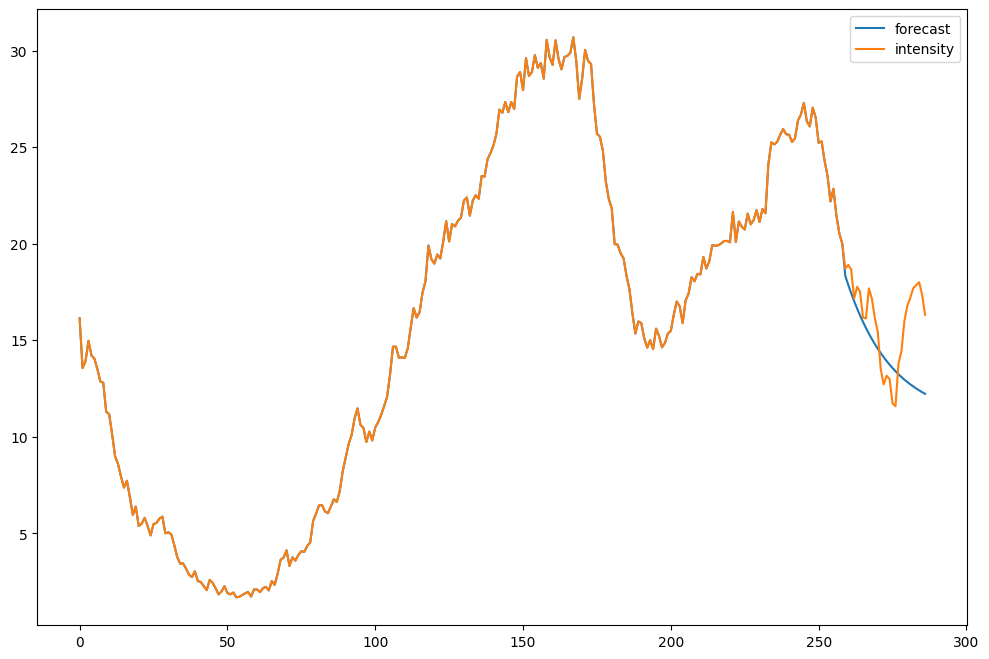

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
start=260
end=287
arima_model= ARIMA(mySeries[7],order=(1,1,2))
model=arima_model.fit()
#model.plot_predict(dynamic=False)
df=pd.DataFrame()
array_of_zeros=np.zeros(287-14)
df['intensity']=np.array(mySeries[7])
intent=np.array(mySeries[7][:end-(end-start+1)])
forecast = model.predict(start=start,end=end,dynamic=True)
print(len(forecast))
df['forecast'] = np.concatenate((intent, forecast))
df[['forecast','intensity']].plot(figsize=(12,8))


print("----",model.summary())

Vamos a calcular el error cuadrático medio de la predicción hecha, pese a que no es muy representativo, pues es una única serie, pero veamos que obtenemos. Al calularlos vemos que para ser ARIMa no es demasiado alto, lo que quiere decir que tenemos que esperar errores bastante menores a este.

In [ ]:
MAE=mean_squared_error(mySeries[7][end-(end-start+1):],forecast)
print(MAE)

0.5638647907865885


# Probamos con distintos tamaños de ventana

Ahora vamos a predecir para distintas ventanas. Para este modelo vamos a entrenarlo con las series de entrenamiento y posteriormente calcular para las series de validación sus errores.

In [ ]:
with open('/content/gdrive/MyDrive/PatronesComportamiento/singleSerieIntenTrT.pkl', 'rb') as file:
    singleSerieTrT = pickle.load(file)


with open('/content/gdrive/MyDrive/PatronesComportamiento/singleSerieIntenValit.pkl', 'rb') as file:
    singleSerieValit= pickle.load(file)


    
with open('/content/gdrive/MyDrive/PatronesComportamiento/singleSerieInten.pkl', 'rb') as file:
        singleSerie=pickle.load(file)

In [ ]:
def spliting_timeseries(timeSerie,w,h):  #w amplitud de la ventana y h >1 si es multiobjetivo
  X, y = [], []  #inicializamos los arrays que guardarán atributos y variable predicha
  for i in range(len(timeSerie) - w): #bucle para iterar sobre todas las muestras de las series 
    X.append(timeSerie[i : i + w+h])  #cogemos desde el elemento en el que estamos hasta los w siguientes
    y.append(timeSerie[i + w:i+w+h])  #aquí cogemos desde el w+1 hasta los h siguientes
  return pd.DataFrame(X), pd.Series(y),X,y

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error

sizes=[70,90,110,140,170,200,230,260,288]
#10,20,30,40,50,70,90,110,140,170,200,230,260,288]
metrics=[]
h=1
for w in sizes:
  print("Ventana de tamaño ", w)
  data_x,data_y,x,y=spliting_timeseries(singleSerieValit,w,h)
  error=[]
  for j in range(len(x)):
    if j==0:

        model = auto_arima(x[j], start_p=1, start_q=1,
                       max_p=5, max_q=5, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=0, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
        orders=model.to_dict()['order']

        
    start=w
    end=w+h
    #arima_model=  ARIMA(x[j],order=(1,1,2))
    '''
    model = auto_arima(x[j], start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=None, D=0, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
    '''
  # Ajustar el modelo ARIMA con los mejores parámetros
    #orders=model.to_dict()['order']
    arima_model=  ARIMA(x[j],order=orders)

    model=arima_model.fit()
    df=pd.DataFrame()
    intent=np.array(x[j][:end-(end-start+1)])
    forecast = model.predict(start=start,end=end-1,dynamic=True)
    MAE=mean_absolute_percentage_error(y[j],forecast)
    error.append(MAE)
  
  metrics.append([w,h,np.mean(np.array(error))])
  print(metrics)
  dfMetrics288 = pd.DataFrame(np.array(metrics),
                   columns=['w','h','mean'])
  

  with open('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArima'+str(w)+'.pkl', 'wb') as file:
        pickle.dump(dfMetrics288,file)
  
  

In [ ]:
from sklearn.metrics import mean_squared_error

wh=[[288,72],[288,36],[288,288]]
metrics=[]
h=1
for v in wh:
  print("Ventana de tamaño ", v[0])
  data_x,data_y,x,y=spliting_timeseries(singleSerieValit,v[0],v[1])
  error=[]
  for j in range(len(x)):
    if(j==0):
      start=v[0]
      end=v[0]+v[1]
      #arima_model=  ARIMA(x[j],order=(1,1,2))
      model = auto_arima(x[j], start_p=1, start_q=1,
                      max_p=5, max_q=5, m=12,
                      start_P=0, seasonal=True,
                      d=None, D=0, trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
      orders=model.to_dict()['order']

# Ajustar el modelo ARIMA con los mejores parámetros
   
    #arima_model=  ARIMA(x[j],order=(1,1,2))
    '''
    model = auto_arima(x[j], start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=None, D=0, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
    '''
  # Ajustar el modelo ARIMA con los mejores parámetros
    
    arima_model=  ARIMA(x[j],order=orders)
    arima_model.initialize_approximate_diffuse() # this line

    model=arima_model.fit()
    df=pd.DataFrame()
    intent=np.array(x[j][:end-(end-start+1)])
    forecast = model.predict(start=start,end=end-1,dynamic=True)
    MAE=mean_absolute_percentage_error(y[j],forecast[:len(y[j])])
    error.append(MAE)
  
  metrics.append([v[0],v[1],np.mean(np.array(error))])
  print(metrics)
  dfMetricsWideh = pd.DataFrame(np.array(metrics),
                   columns=['w','h','mean'])

  with open('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArimaWideW'+str(v[0])+'h'+str(v[1])+'.pkl', 'wb') as file:
      pickle.dump(dfMetricsWideh,file)
  

In [ ]:
metrics.append([v[0],v[1],np.mean(np.array(error))])
print(metrics)
dfMetricsWideh = pd.DataFrame(np.array(metrics),
                   columns=['w','h','mean'])

with open('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArimaWideW'+str(v[0])+'h'+str(v[1])+'.pkl', 'wb') as file:
      pickle.dump(dfMetricsWideh,file)

[[144, 144, 2.3301969853820412], [144, 144, 2.3301969853820412]]


# Resultados de las predicciones

In [ ]:

met=pd.read_pickle('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArima'+str(260)+'.pkl')
met


,w,h,mean
0,70.0,1.0,0.055281
1,90.0,1.0,0.054937
2,110.0,1.0,0.054493
3,140.0,1.0,0.054080
4,170.0,1.0,0.054812
5,200.0,1.0,0.055001
6,230.0,1.0,0.054417
7,260.0,1.0,0.053444


In [ ]:

met=pd.read_pickle('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArimaWideW144h144.pkl')
met


,w,h,mean
0,144.0,144.0,2.330197
1,144.0,144.0,2.330197


In [ ]:

met1=pd.read_pickle('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArimaWideW288h144.pkl')
met1.index=[2,3]
met1


,w,h,mean
2,288.0,50.0,0.74907
3,288.0,144.0,2.33820


In [ ]:
met2=pd.read_pickle('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArimaWideW288h288.pkl')
met2.index=[4,5,6]
met2

,w,h,mean
4,288.0,72.0,1.192591
5,288.0,36.0,0.509421
6,288.0,288.0,2.661632


In [ ]:



met3=pd.read_pickle('/content/gdrive/MyDrive/PatronesComportamiento/metricasArima/dftMetricsArimaWideW288h36.pkl')
met3
met3.index=[7,8]

concat=pd.concat([met,met1, met2,met3])
concat=concat.sort_values(by=['mean'])
concat

,w,h,mean
5,288.0,36.0,0.509421
8,288.0,36.0,0.509421
2,288.0,50.0,0.749070
4,288.0,72.0,1.192591
7,288.0,72.0,1.192591
0,144.0,144.0,2.330197
1,144.0,144.0,2.330197
3,288.0,144.0,2.338200
6,288.0,288.0,2.661632


In [ ]:
concat=concat.drop_duplicates(keep='last')
concat.index=[1,2,3,4,5,6]



In [ ]:
concat

,w,h,mean
1,288.0,36.0,0.509421
2,288.0,50.0,0.749070
3,288.0,72.0,1.192591
4,144.0,144.0,2.330197
5,288.0,144.0,2.338200
6,288.0,288.0,2.661632
